In [1]:
# Import required libraries
import os
import sys
import torch
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings("ignore")

# Add project root to path for imports
project_root = os.path.abspath('.')
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Import project modules from new structure
from configs.config import Config
from src.utils.data_utils import (
    load_labels_from_csv, 
    SignLanguageDataset, 
    create_data_loaders,
    flip_keypoints,
    transform_keypoints
)
from src.utils.model_utils import (
    create_adjacency_matrix,
    create_model
)
from src.models.model import (
    HGC_LSTM
)
from src.utils.train_utils import (
    train_model
)
from src.utils.visualization_utils import (
    visualize_training_process,
    analyze_model_performance
)

print("✅ All modules imported successfully!")
print(f"📦 Project structure reorganized with modular imports")
print(f"🐍 Python: {sys.version}")
print(f"🔥 PyTorch: {torch.__version__}")
print(f"🔧 CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"🔧 CUDA Device: {torch.cuda.get_device_name(0)}")
print()

# Initialize configuration
config = Config()
print("🔧 Configuration loaded from configs/config.py")
print(f"📊 Data from: {config.data.input_kp_path}")
print(f"💾 Models save to: {config.model.checkpoint_dir}")
print(f"📈 Plots save to: {config.output.plots_dir}")

✅ All modules imported successfully!
📦 Project structure reorganized with modular imports
🐍 Python: 3.10.16 (main, Dec 11 2024, 16:24:50) [GCC 11.2.0]
🔥 PyTorch: 2.7.0+cu126
🔧 CUDA Available: True
🔧 CUDA Device: NVIDIA GeForce RTX 3070 Ti

🔧 Configuration loaded from configs/config.py
📊 Data from: dataset/Keypoints
💾 Models save to: outputs/models
📈 Plots save to: outputs/plots


In [2]:
# Import data utilities
from src.utils.data_utils import load_labels_from_csv

# Load labels
video_to_label_mapping, label_to_idx, unique_labels, id_to_label_mapping = load_labels_from_csv(None, config)
num_classes = len(unique_labels)

In [3]:
# Import data augmentation and dataset utilities
from src.utils.data_utils import flip_keypoints, transform_keypoints, SignLanguageDataset

In [4]:
# Create datasets with stratified split and augmentation
print("[INFO] Creating datasets...")
keypoints_dir = config.data.keypoints_output_dir

# Set random seed for reproducible splits
np.random.seed(42)

# Get parameters from config
use_strategy = config.data.use_strategy


# Training uses augmentation, validation does not (for fair evaluation)
train_augmentations = getattr(config.data, 'augmentations', [])
val_augmentations = [] 

print(f"Configuration:")
print(f"   Split strategy: {'Stratified' if use_strategy else 'Random'}")
print(f"   Train augmentations: {train_augmentations if train_augmentations else 'None'}")
print(f"   Val augmentations: {val_augmentations if val_augmentations else 'None (for fair evaluation)'}")
if 'translation' in train_augmentations:
    print(f"   Translation range: ±{config.data.translation_range}")
if 'scaling' in train_augmentations:
    print(f"   Scale range: ±{config.data.scale_range}")

train_dataset = SignLanguageDataset(
    keypoints_dir, video_to_label_mapping, label_to_idx, config,
    split_type='train', 
    augmentations=train_augmentations,
    use_strategy=use_strategy
)

val_dataset = SignLanguageDataset(
    keypoints_dir, video_to_label_mapping, label_to_idx, config,
    split_type='val', 
    augmentations=val_augmentations,
    use_strategy=use_strategy
)

print(f"\n[INFO] Dataset summary:")
print(f"  Total classes: {len(unique_labels)}")
print(f"  Train samples: {len(train_dataset)}")
print(f"  Val samples: {len(val_dataset)}")
print(f"  Strategy: {'Stratified' if use_strategy else 'Random'} split")

[INFO] Creating datasets...
Configuration:
   Split strategy: Stratified
   Train augmentations: ['translation', 'scaling']
   Val augmentations: None (for fair evaluation)
   Translation range: ±0.1
   Scale range: ±0.1
 Using stratified split strategy
 TRAIN dataset: 240 original files
 Augmentation enabled: 960 total samples (x4)
  - Augmentations: ['translation', 'scaling']
  - Total combinations: 4
  - Combinations: ['original', 'translation', 'scaling', 'translation+scaling']
 TRAIN class distribution:
  Class 1: 16 samples
  Class 2: 16 samples
  Class 3: 16 samples
  Class 4: 16 samples
  Class 5: 16 samples
  Class 6: 16 samples
  Class 7: 16 samples
  Class 8: 16 samples
  Class 9: 16 samples
  Class 10: 16 samples
  Class 11: 16 samples
  Class 12: 16 samples
  Class 13: 16 samples
  Class 14: 16 samples
  Class 15: 16 samples
 ✓ Balanced: 16 samples per class
 Using stratified split strategy
 VAL dataset: 60 original files
 No augmentation enabled: 60 total samples
 VAL cla

In [5]:
# Import data loader utility
from src.utils.data_utils import create_data_loaders

# Create data loaders
print("\n[INFO] Creating data loaders...")
train_loader, val_loader = create_data_loaders(train_dataset, val_dataset, config)


[INFO] Creating data loaders...
 Train batches: 15
 Valid batches: 1
 Batch size: 64
 Data Augmentation (translation + scaling): 240 original → 960 total samples
 Augmentation combinations: ['original', 'translation', 'scaling', 'translation+scaling']
 Sample keypoints shape: torch.Size([64, 60, 75, 2])
 Sample labels shape: torch.Size([64])


In [6]:
# Import model utilities
from src.utils.model_utils import create_adjacency_matrix

A = create_adjacency_matrix(config)
print(f"[INFO] Adjacency matrix shape: {A.shape}")
print(f"[INFO] Number of vertices: {config.hgc_lstm.num_vertices}")

[INFO] Adjacency matrix shape: torch.Size([75, 75])
[INFO] Number of vertices: 75


In [7]:
# Import model classes and utilities
from src.utils.model_utils import create_model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = create_model(config, A, num_classes, device)

Model created with 780177 parameters


In [8]:
print("[INFO] Starting training...")
print(f"[INFO] Training configuration:")
print(f"  - Epochs: {config.training.num_epochs}")
print(f"  - Batch size: {config.training.batch_size}")
print(f"  - Learning rate: {config.training.learning_rate}")
print(f"  - Optimizer: {config.training.optimizer}")
print(f"  - Scheduler: {config.training.scheduler}")
print(f"  - Early stopping patience: {config.training.early_stopping_patience}")
history = train_model(model, train_loader, val_loader, config, device)

[INFO] Starting training...
[INFO] Training configuration:
  - Epochs: 300
  - Batch size: 64
  - Learning rate: 0.001
  - Optimizer: adam
  - Scheduler: step
  - Early stopping patience: 50
Epoch 001/300 | Train Loss: 2.5386 Acc: 18.75% | Val Loss: 2.6925 Acc: 06.67% | LR: 0.00100000
Epoch 002/300 | Train Loss: 1.8525 Acc: 33.65% | Val Loss: 2.5045 Acc: 16.67% | LR: 0.00100000
Epoch 003/300 | Train Loss: 1.5867 Acc: 41.04% | Val Loss: 1.3178 Acc: 48.33% | LR: 0.00100000
Epoch 004/300 | Train Loss: 1.6127 Acc: 41.15% | Val Loss: 1.1002 Acc: 61.67% | LR: 0.00100000
Epoch 005/300 | Train Loss: 1.3954 Acc: 49.79% | Val Loss: 0.9862 Acc: 61.67% | LR: 0.00100000
Epoch 006/300 | Train Loss: 1.2825 Acc: 53.12% | Val Loss: 0.8028 Acc: 73.33% | LR: 0.00100000
Epoch 007/300 | Train Loss: 1.1709 Acc: 58.33% | Val Loss: 0.6959 Acc: 81.67% | LR: 0.00100000
Epoch 008/300 | Train Loss: 1.0360 Acc: 64.58% | Val Loss: 0.8086 Acc: 66.67% | LR: 0.00100000
Epoch 009/300 | Train Loss: 1.0020 Acc: 64.48% | 

# Training Process Visualization

This section provides essential visualization of the training process including:
- **Loss curves**: Training and validation loss over epochs
- **Accuracy curves**: Training and validation accuracy over epochs  
- **Confusion matrix**: Model performance analysis on validation set

[INFO] Generating training process visualization...
Training curves saved to: training_plots/training_curves.png


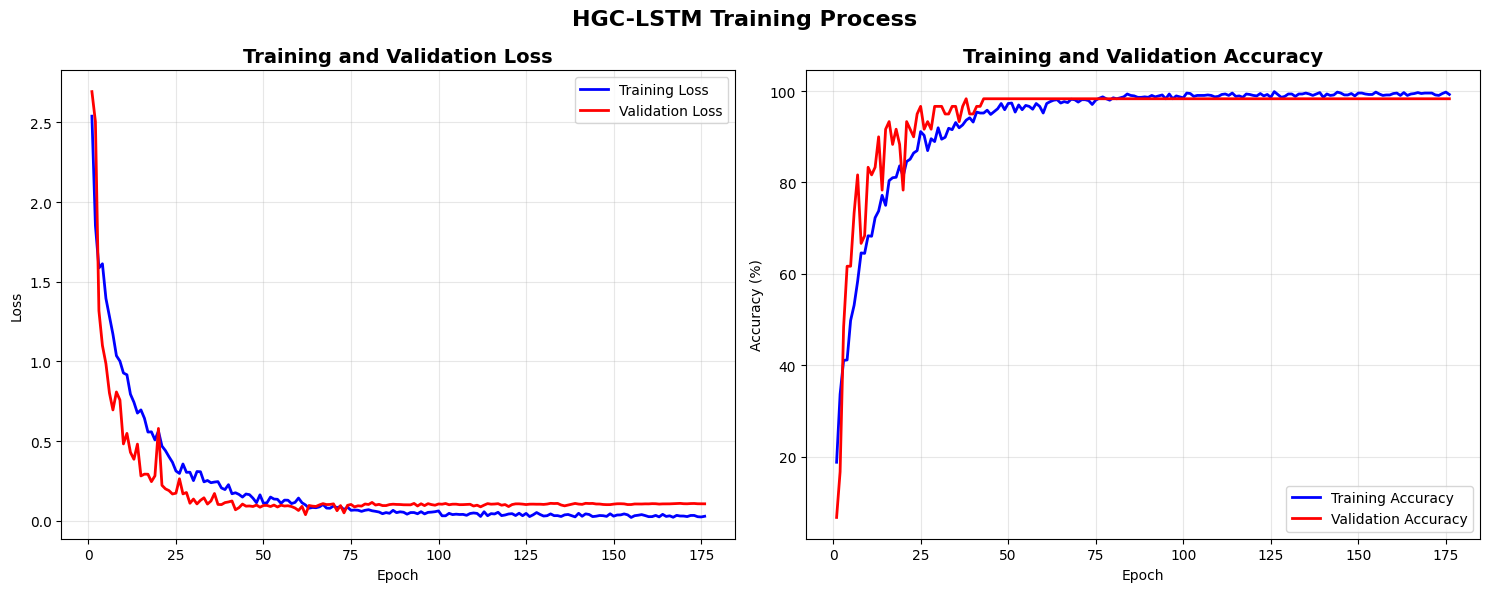


📊 TRAINING SUMMARY:
   Best Validation Accuracy: 98.33% (Epoch 38)
   Final Training Accuracy: 99.27%


In [9]:
# Import visualization utilities
from src.utils.visualization_utils import visualize_training_process

# Visualize training process
print("[INFO] Generating training process visualization...")
training_fig = visualize_training_process(history, config, save_plots=True)

Model loaded from outputs/models/best_hgc_lstm.pth
Model created with 780177 parameters
[INFO] Analyzing model performance...
 Analyzing model performance on validation set...
Confusion matrix saved to: training_plots/confusion_matrix.png


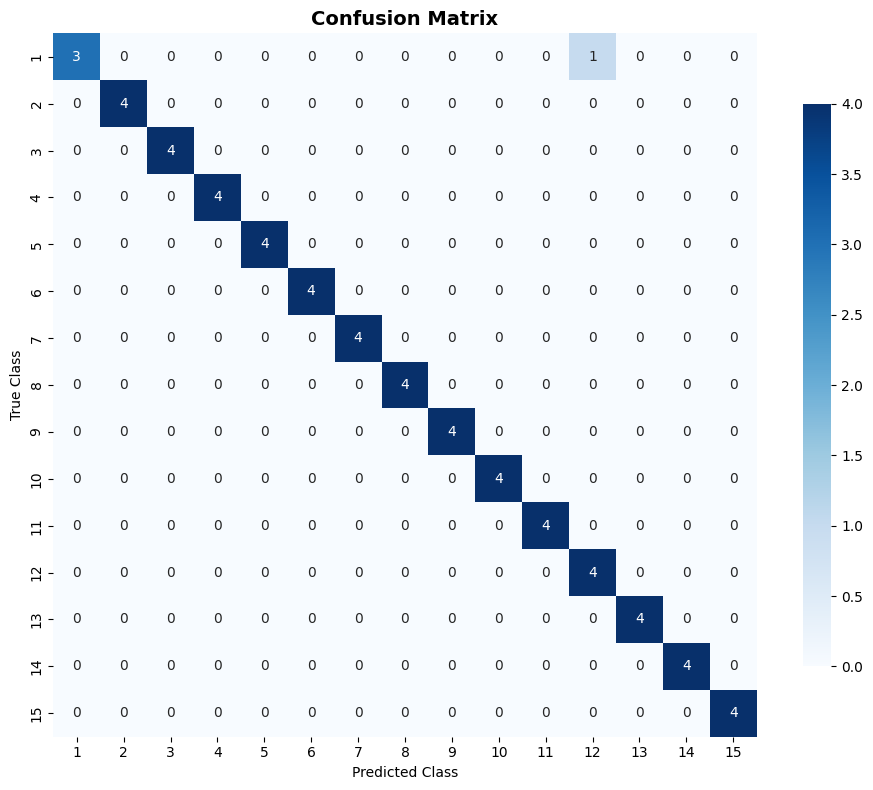


CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Class_1       1.00      0.75      0.86         4
     Class_2       1.00      1.00      1.00         4
     Class_3       1.00      1.00      1.00         4
     Class_4       1.00      1.00      1.00         4
     Class_5       1.00      1.00      1.00         4
     Class_6       1.00      1.00      1.00         4
     Class_7       1.00      1.00      1.00         4
     Class_8       1.00      1.00      1.00         4
     Class_9       1.00      1.00      1.00         4
    Class_10       1.00      1.00      1.00         4
    Class_11       1.00      1.00      1.00         4
    Class_12       0.80      1.00      0.89         4
    Class_13       1.00      1.00      1.00         4
    Class_14       1.00      1.00      1.00         4
    Class_15       1.00      1.00      1.00         4

    accuracy                           0.98        60
   macro avg       0.99      0.98      0.98        60
wei

In [10]:
# Import model performance analysis
from src.utils.visualization_utils import analyze_model_performance
from src.utils.model_utils import load_model
model_save_path = os.path.join(config.model.checkpoint_dir, config.model.save_name)
# model_save_path = os.path.join(config.model.checkpoint_dir, "best_hgc_lstm_321415.pth")
model = load_model(model_save_path, config)
# Analyze model performance
print("[INFO] Analyzing model performance...")
performance_results = analyze_model_performance(model, val_loader, device, config, unique_labels, id_to_label_mapping)

[INFO] Visualizing dual attention weights...
This shows both:
  - Joint Attention: Which keypoints are important (after GCN)
  - Temporal Attention: Which time steps are important (after LSTM)
Dual attention weights for sample 1 saved to: attention_plots/dual_attention_sample_1.png


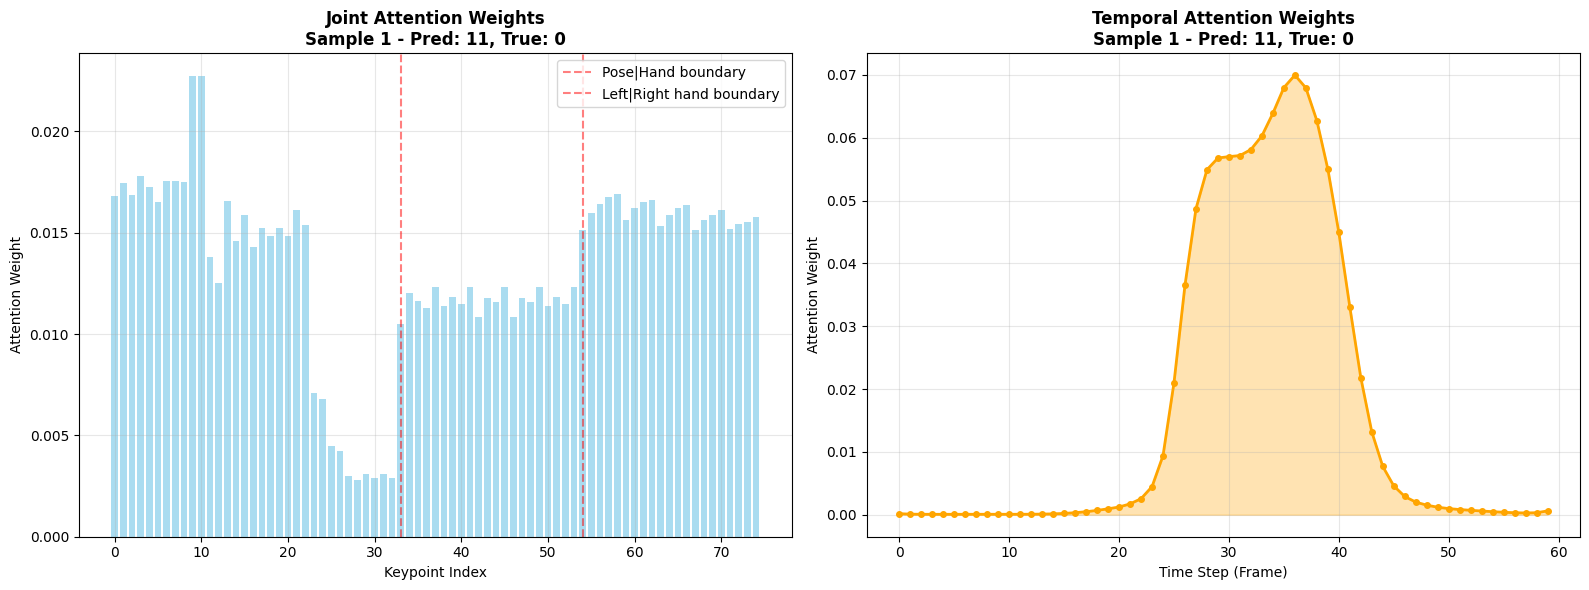

Dual attention weights for sample 2 saved to: attention_plots/dual_attention_sample_2.png


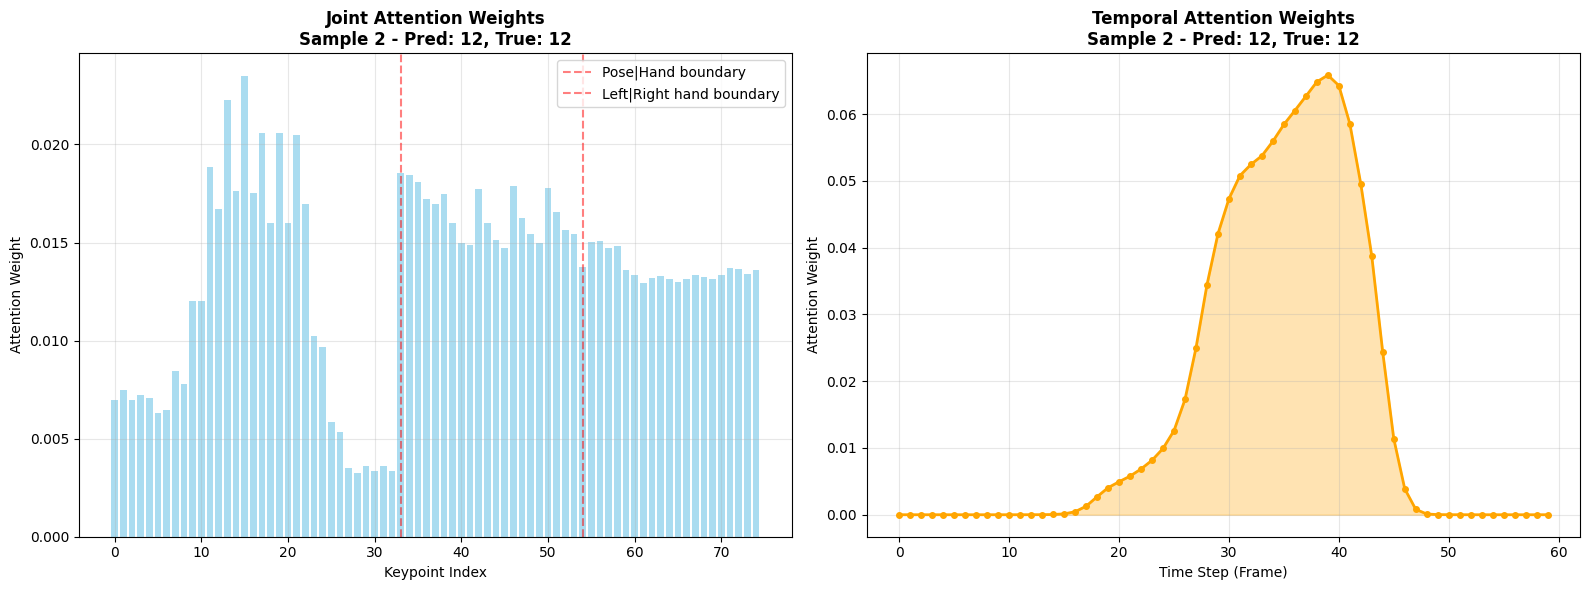

Dual attention weights for sample 3 saved to: attention_plots/dual_attention_sample_3.png


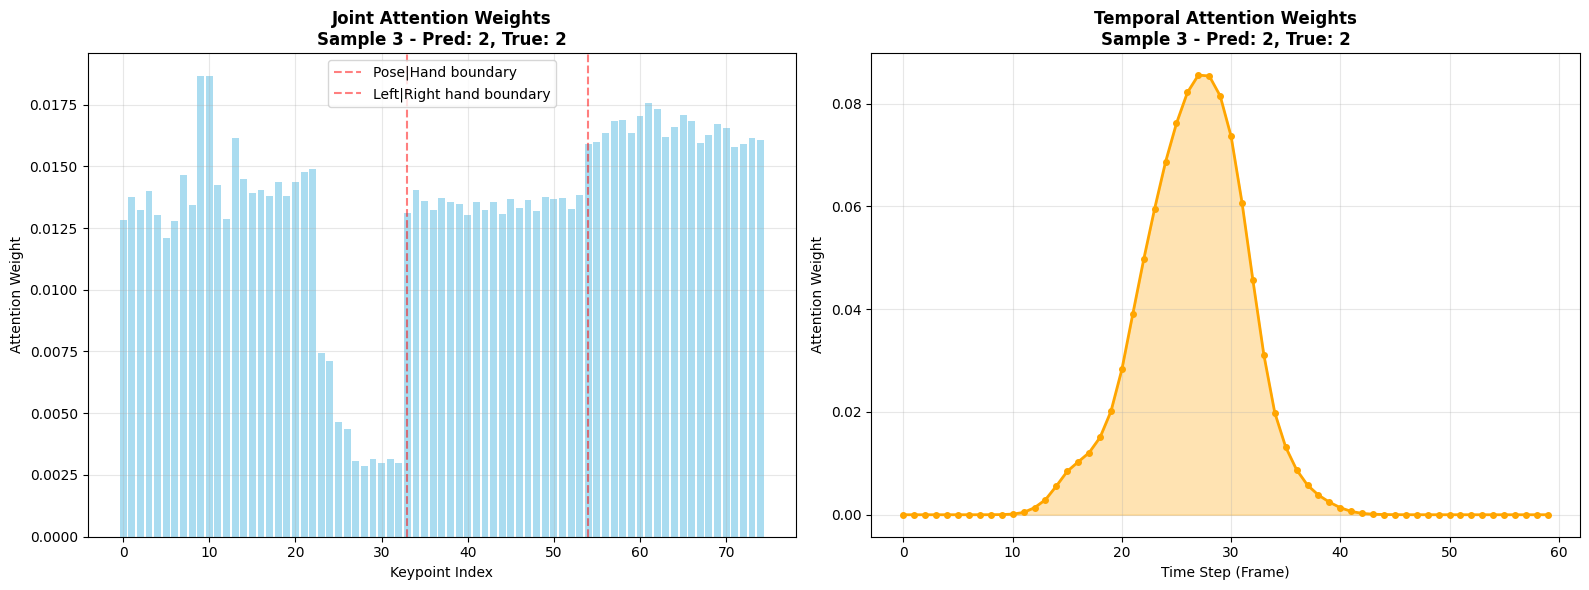

In [11]:
# Import the new dual attention visualization functions
from src.utils.visualization_utils import visualize_dual_attention_weights, visualize_attention_heatmap

# Visualize dual attention weights (joint + temporal)
print("[INFO] Visualizing dual attention weights...")
print("This shows both:")
print("  - Joint Attention: Which keypoints are important (after GCN)")
print("  - Temporal Attention: Which time steps are important (after LSTM)")

dual_attention_fig = visualize_dual_attention_weights(model, val_loader, device, config, num_samples=3)

[INFO] Visualizing joint attention heatmap...
This shows the actual attention weights from the joint attention layer
(Time steps × Keypoints) - directly from model's attention mechanism
Joint attention heatmap for sample 1 saved to: attention_plots/joint_attention_heatmap_sample_1.png


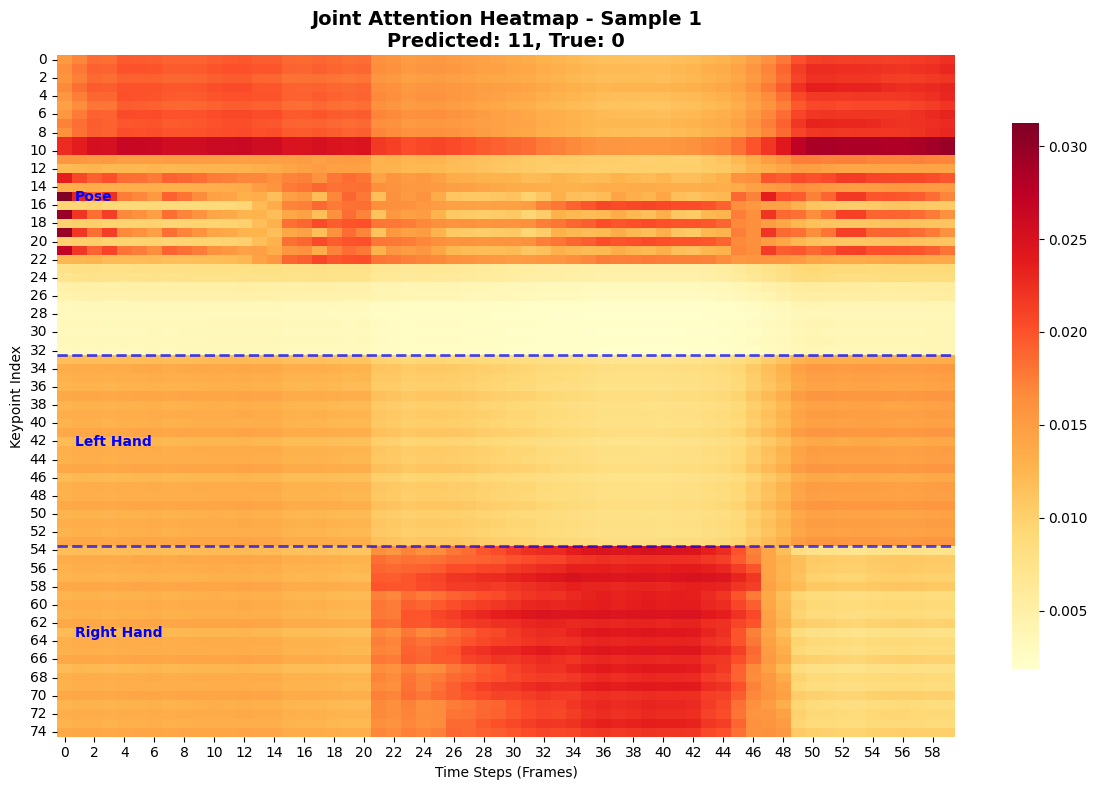

Joint attention heatmap for sample 2 saved to: attention_plots/joint_attention_heatmap_sample_2.png


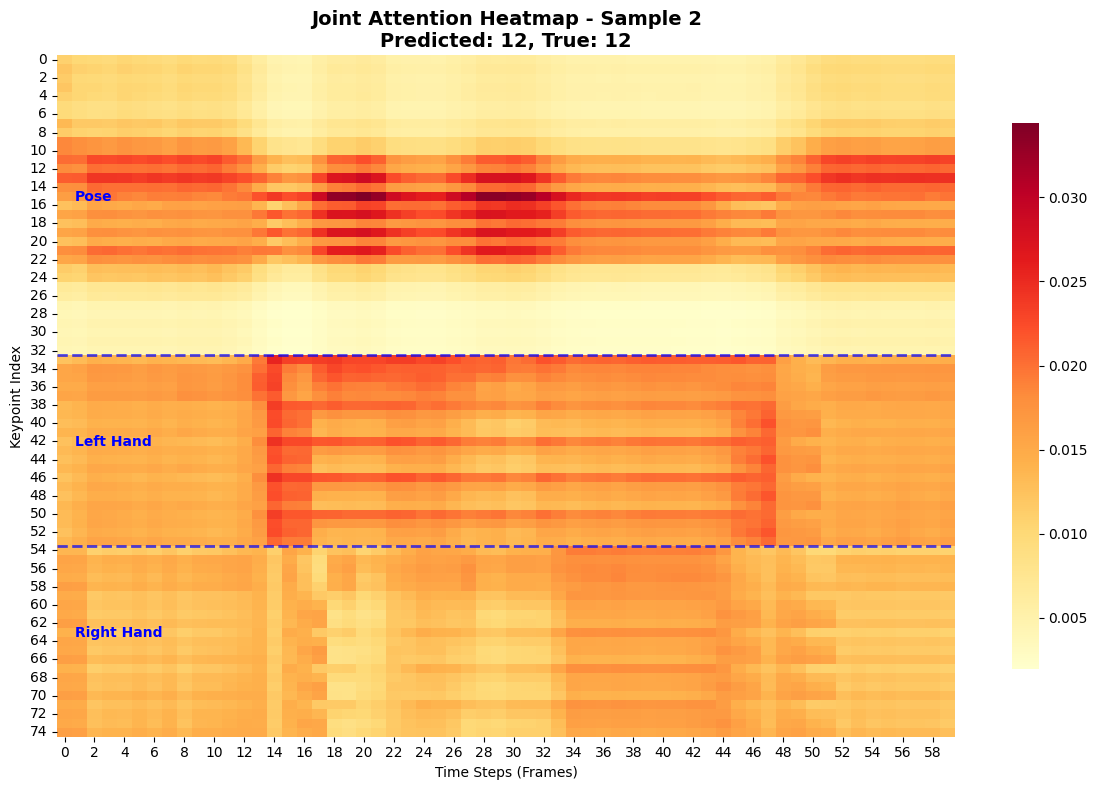

In [12]:
# Visualize joint attention as detailed heatmap
print("[INFO] Visualizing joint attention heatmap...")
print("This shows the actual attention weights from the joint attention layer")
print("(Time steps × Keypoints) - directly from model's attention mechanism")

joint_attention_heatmap_fig = visualize_attention_heatmap(model, val_loader, device, config, num_samples=2)

In [13]:
from scripts.inference import predict_from_video
import glob
from src.utils.detector import MediaPipeProcessor
test_dir = "data/datatest"  # Replace with your video path
videos = glob.glob(os.path.join(test_dir, "*.mp4"))
count = 0
config = Config()
processor = MediaPipeProcessor(config)
for video_path in videos:
    filename = os.path.basename(video_path)
    number = int(filename.split('_')[1].split('.')[0])
    label, res = predict_from_video(model, processor, id_to_label_mapping, config, device, test_dir+'/'+filename, thresh_hold=0.2)
    print(f"{number}: {res}")
    if number == res:
        count += 1
print(f"{count}/{len(videos)} videos predicted correctly.")

E0000 00:00:1756463234.739576   17572 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756463234.742330   17572 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


🎬 Processing video: data/datatest/test_014.mp4


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


Predicted class: 5, label: conga, confidence: 0.9902700185775757
14: 5
🎬 Processing video: data/datatest/test_004.mp4
Predicted class: 4, label: concua, confidence: 0.9992355108261108
4: 4
🎬 Processing video: data/datatest/test_009.mp4
Predicted class: 2, label: concho, confidence: 0.6312016248703003
9: 2
🎬 Processing video: data/datatest/test_013.mp4
Predicted class: 6, label: congau, confidence: 0.7431817650794983
13: 6
🎬 Processing video: data/datatest/test_010.mp4
Predicted class: 10, label: conong, confidence: 0.9357720613479614
10: 10
🎬 Processing video: data/datatest/test_001.mp4
Predicted class: 1, label: conca, confidence: 0.9977006316184998
1: 1
🎬 Processing video: data/datatest/test_011.mp4
Predicted class: 11, label: conruoi, confidence: 0.9700899124145508
11: 11
🎬 Processing video: data/datatest/test_006.mp4
Predicted class: 8, label: conmeo, confidence: 0.9295713305473328
6: 8
🎬 Processing video: data/datatest/test_002.mp4
Predicted class: 2, label: concho, confidence: 0.